In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import scipy.io as scipy
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline

In [3]:
df = pd.read_csv("Downloads/ex2data2.csv", sep=',')

In [8]:
X = df.iloc[:, [0, 1]].values
y = df.iloc[:, 2].values
print(X.shape, y.shape)

(117, 2) (117,)


In [9]:
 x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

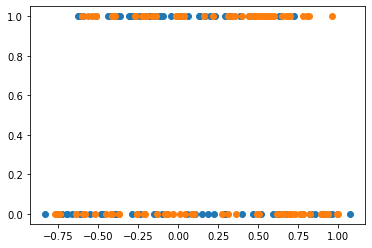

In [10]:
#Data exploration for Train Data
plt.plot(x_train,y_train,'o')


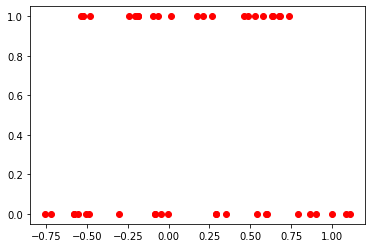

In [11]:
#Data Exploration for Test Data
plt.plot(x_test,y_test,'ro')

In [12]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [13]:
#Cost Function
def CostFunc(X, y, omega, lamb):
    y_hat = sigmoid(X * omega)
    one = np.multiply(y, np.log(y_hat))
    two = np.multiply((1 - y), np.log(1 - y_hat))
    reg = (lamb / 2 * len(X)) * np.sum(np.power(omega[1:,:], 2))
    return (-1/len(X)) * np.sum(one + two) + reg

In [14]:
#Stochastic Gradient descent to obtain optimal omega
def sgd(X, y, theta, rho, minibatch_size, lamb=0, threshold=0.0001, iters=1000):
    temp = np.matrix(np.zeros(theta.shape))
    parameters = theta.ravel().shape[1]
    cost = [np.inf]
    
    while True:
        for b in range(math.ceil(len(X)/minibatch_size)):
            # generates random samples without replacement, all unique
            random_idx = np.random.choice(len(X), size=min(len(X), minibatch_size), replace = False)

            # Get pair of (X, y) of the current minibatch/chunk
            X_mini = X[random_idx]
            y_mini = y[random_idx]
            
            error = sigmoid(np.dot(X_mini,theta)) - y_mini
            
            for j in range(parameters):
                term = np.multiply(error, X_mini[:,j])
                temp[j,0] = theta[j,0] - ((rho/ len(X_mini)) * (np.sum(term) + lamb * theta[j,0]))

            theta = temp
            
        cost.append(CostFunc(X, y, theta, lamb))
        
        #print(cost[-1])
        
        if (cost[-2]-cost[-1]) > 0 and (cost[-2]-cost[-1]) < threshold:
            break
        
    return theta, cost

In [15]:
lambdas = [0.01,0.03,0.1,0.3,1]

In [16]:
def regularizationParameter(X, y, kfolds, alpha, minibatch_size, threshold=0.0001, lambda_list = lambdas):
    theta1 = np.matrix(np.zeros((X.shape[1],1)))
    
    shuffled_idx = np.random.choice(len(X), size=len(X), replace = False)
    idx_per_fold = math.floor(len(X)/kfolds)
    if len(X) % kfolds !=0:
        kfolds+=1
        
    lambda_errorlist = defaultdict(list)
    
    for lamb in lambdas:
        for k in range(kfolds):
            #holdout_idx = np.arange(k*idx_per_fold, (k+1)*idx_per_fold)
            holdout_idx = shuffled_idx[k*idx_per_fold : (k+1)*idx_per_fold]
            #X_holdout = X[k*idx_per_fold : (k+1)*idx_per_fold]
            #X_training = np.delete(X,holdout_idx, axis=0)
            # Holdout data - kth fold
            X_holdout = X[holdout_idx]
            y_holdout = y[holdout_idx]
            # Training data - other than kth fold
            X_training = X[~holdout_idx]
            y_training = y[~holdout_idx]
            
            omega1, _ = sgd(X_training, y_training, theta1, alpha, minibatch_size, lamb, threshold)
            holdout_error_lk = CostFunc(X_holdout, y_holdout, omega1, lamb)
            
            lambda_errorlist[lamb].append(holdout_error_lk)
            #print("{0}th holdout error(λ={1}): {2}".format(k, lamb, holdout_error_lk))
        print("Average error on k-holdout sets for lamda={0} is {1}".format(lamb,np.mean(lambda_errorlist[lamb])))
    lambda_optimal = min(lambda_errorlist, key= lambda l: np.mean(lambda_errorlist[l]))
    
    return lambda_optimal

In [17]:
#For Plotting
def plot(X_train, y_train, X_test, y_test, theta, title):
    # Dataframe with X and y concatenated
    test_df = pd.DataFrame(data=np.column_stack((X_test[:,1:],y_test)), columns=['X1','X2','Y'])
    train_df = pd.DataFrame(data=np.column_stack((X_train[:,1:],y_train)), columns=['X1','X2','Y'])

    positive_test = test_df[test_df['Y'].isin([1])]  
    negative_test = test_df[test_df['Y'].isin([0])]

    positive_train = train_df[train_df['Y'].isin([1])]  
    negative_train = train_df[train_df['Y'].isin([0])]
    
    fig, ax = plt.subplots(figsize=(12,8))  

    w0 = theta.item(0)
    w1, w2 = theta.item(1), theta.item(2)

    x_hyperplane = np.arange(math.floor(train_df['X1'].min()), math.ceil(train_df['X1'].max()),0.1)
    y_hyperplane = (-w0-w1*x_hyperplane)/w2

    ax.scatter(positive_train['X1'], positive_train['X2'], s=50, marker='x', label='Train Positive', c='b')  
    ax.scatter(positive_test['X1'], positive_test['X2'], s=50, marker='x', label='Test Positive', facecolors='none', edgecolors='b')  
    
    ax.scatter(negative_train['X1'], negative_train['X2'], s=50, marker='o', label='Train Negative', c='r')  
    ax.scatter(negative_test['X1'], negative_test['X2'], s=50, marker='o', label='Test Negative', facecolors='none', edgecolors='r')  
    
    plt.plot(x_hyperplane, y_hyperplane, 'k-', label='Decision Boundary')

    plt.legend(bbox_to_anchor=(1, 0), loc="upper right", ncol=5,
                bbox_transform=fig.transFigure, fontsize = 'medium', columnspacing = 0.5)  
    
    ax.set_xlabel('X1')
    ax.set_ylabel('X2') 
    plt.title(title)
    fig.tight_layout()
    plt.show()

In [18]:
#Function to predict classes
def predict(theta, X):  
    prob = sigmoid(X * theta)
    return [1 if x >= 0.5 else 0 for x in prob]

In [19]:
#Adding intercept to data 
X1_train = np.hstack((np.ones((x_train.shape[0], 1)), x_train))
X1_test = np.hstack((np.ones((x_test.shape[0], 1)), x_test))

In [20]:
#Finding regularization parameter lambda
alpha = 0.0001
minibatch_size = 5
kfolds_10 = 10

lambda_optimal1 = regularizationParameter(X1_train, y_train, kfolds_10, alpha, minibatch_size)
print("Optimal value for lamda:{0}".format(lambda_optimal1))

Average error on k-holdout sets for lamda=0.01 is 5.9708319963600625
Average error on k-holdout sets for lamda=0.03 is 5.9708900878957785
Average error on k-holdout sets for lamda=0.1 is 5.968543128033674
Average error on k-holdout sets for lamda=0.3 is 5.962784429281524
Average error on k-holdout sets for lamda=1 is 5.94619436952882
Optimal value for lamda:1


In [21]:
#Assigning theta to 0
theta = np.matrix(np.zeros((X1_train.shape[1],1)))
theta

matrix([[0.],
        [0.],
        [0.]])

In [22]:
#Training theta
theta_sg1, cost_sg1 = sgd(X1_train, y_train, theta,alpha, minibatch_size=10, lamb=lambda_optimal1, threshold=0.0001)
print("Theta for training data:\n",theta_sg1)

Theta for training data:
 [[-0.0010257 ]
 [-0.00486666]
 [ 0.00352003]]


In [31]:
#Classification accuracy on train data
predictions_trn = predict(theta_sg1, X1_train)  
metrics.accuracy_score(predictions_trn, y_train.tolist(), normalize=True, sample_weight=None)

0.5591397849462365

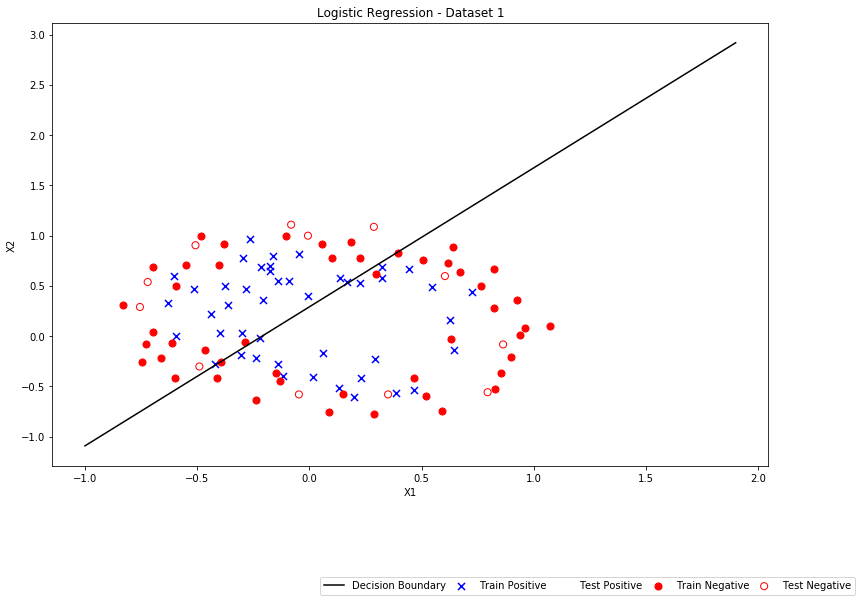

In [32]:
plot(X1_train, y_train, X1_test, y_test, theta_sg1, title = "Logistic Regression - Dataset 1")